In [2]:
#the preamble:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

/Users/philliptan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/philliptan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#beautiful soup
from bs4 import BeautifulSoup

import requests

def get_data(seasons):
    url = 'http://fftoday.com/stats/playerstats.php?Season={}&GameWeek=Season&PosID=20&LeagueID=1'
    
    player_data = []

    header = ['PLAYER','TEAM','GAMES','ATTEMPTS','RUSH_YARDS', 'RUSH_TDs', 'TARGETS', 'REC', 'REC_YARDS', 'REC_TD', 'FPTS', 'FPTS/G']
    
    for season in seasons:
        file_url = url.format(season) 
        response = requests.get(file_url) #pulling info from url
        
        soup = BeautifulSoup(response.text)
        
        player_list = soup.find('tr', {'bgcolor':'#eeeeee'})
        
        for row in player_list.findAll("tr")[2:]: #ignore the first two tr, they are headers.
            #we also need a column for year, and ftps/g
            row_dict={}
            
            for i, cell_data in enumerate(row.findAll("td")):            
                row_dict[header[i]] = cell_data.text

            row_dict['YEAR'] = season

            player_data.append(row_dict)
            
    return player_data

seasons = range(2000, 2017)
all_seasons = get_data(seasons)


/Users/philliptan/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/philliptan/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [4]:
len(all_seasons) #this gives me total players

850

In [48]:
#making the data frame
df = pd.DataFrame(all_seasons)
df.head()
#no targets for certain years, drop rows

,ATTEMPTS,FPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR
0,253,374.9,26.8,14,1. Marshall Faulk,81,8,830,18,"1,359",,STL,2000
1,387,338.3,21.1,16,2. Edgerrin James,63,5,594,13,"1,709",,IND,2000
2,404,292.0,18.3,16,3. Eddie George,50,2,453,14,"1,507",,TEN,2000
3,297,256.9,16.1,16,4. Mike Anderson,23,0,169,15,"1,500",,DEN,2000
4,263,251.4,15.7,16,5. Ahman Green,73,3,559,10,"1,175",,GB,2000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 13 columns):
ATTEMPTS      850 non-null object
FPTS          850 non-null object
FPTS/G        850 non-null object
GAMES         850 non-null object
PLAYER        850 non-null object
REC           850 non-null object
REC_TD        850 non-null object
REC_YARDS     850 non-null object
RUSH_TDs      850 non-null object
RUSH_YARDS    850 non-null object
TARGETS       850 non-null object
TEAM          850 non-null object
YEAR          850 non-null int64
dtypes: int64(1), object(12)
memory usage: 86.4+ KB


In [51]:
df.dropna(axis=0).head()

,ATTEMPTS,FPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR
0,253,374.9,26.8,14,1. Marshall Faulk,81,8,830,18,"1,359",,STL,2000
1,387,338.3,21.1,16,2. Edgerrin James,63,5,594,13,"1,709",,IND,2000
2,404,292.0,18.3,16,3. Eddie George,50,2,453,14,"1,507",,TEN,2000
3,297,256.9,16.1,16,4. Mike Anderson,23,0,169,15,"1,500",,DEN,2000
4,263,251.4,15.7,16,5. Ahman Green,73,3,559,10,"1,175",,GB,2000


In [52]:
df['PLAYER'] = df.PLAYER.map(lambda x: x[3:].replace('.', ''))
df['PLAYER'].head()

0     Marshall Faulk
1     Edgerrin James
2       Eddie George
3      Mike Anderson
4        Ahman Green
Name: PLAYER, dtype: object

In [53]:
df['RUSH_YARDS'] = df['RUSH_YARDS'].str.replace(',', '').astype(int) #I could have done inplace=True..
#get rid of that comma and turn into an int

In [54]:
df[['FPTS', 'FPTS/G']] = df[['FPTS', 'FPTS/G']].astype(float)
#I want these two as floats.

In [55]:
df = df[df.TARGETS != ''] #recreate the df to be all the rows where the TARGET column does NOT equal ''

In [56]:
df[['ATTEMPTS','GAMES','REC','REC_TD','REC_YARDS','RUSH_TDs','TARGETS']] = df[['ATTEMPTS','GAMES','REC','REC_TD','REC_YARDS', 'RUSH_TDs','TARGETS']].astype(int)
#I set these as ints, except for TARGETS because some targets are null since nfl didn't keep them from prior to 2004.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650 entries, 200 to 849
Data columns (total 13 columns):
ATTEMPTS      650 non-null int64
FPTS          650 non-null float64
FPTS/G        650 non-null float64
GAMES         650 non-null int64
PLAYER        650 non-null object
REC           650 non-null int64
REC_TD        650 non-null int64
REC_YARDS     650 non-null int64
RUSH_TDs      650 non-null int64
RUSH_YARDS    650 non-null int64
TARGETS       650 non-null int64
TEAM          650 non-null object
YEAR          650 non-null int64
dtypes: float64(2), int64(9), object(2)
memory usage: 71.1+ KB


In [58]:
df.head()

,ATTEMPTS,FPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR
200,353,306.6,19.2,16,Shaun Alexander,23,4,170,16,1696,38,SEA,2004
201,322,299.6,18.7,16,Tiki Barber,52,2,578,13,1518,79,NYG,2004
202,339,285.6,19.0,15,LaDainian Tomlinson,53,1,441,17,1335,66,SD,2004
203,371,278.2,17.4,16,Curtis Martin,41,2,245,12,1697,49,NYJ,2004
204,301,261.6,17.4,15,Domanick Williams,69,1,596,13,1180,85,HOU,2004


In [59]:
df.groupby(['PLAYER','YEAR'])['TEAM'].count().sort_values(ascending = False).head() #clean up the player with AP's name. 

PLAYER            YEAR
 Adrian Peterson  2007    2
 Zach Zenner      2016    1
 Ezekiel Elliott  2016    1
 Frank Gore       2008    1
                  2007    1
Name: TEAM, dtype: int64

In [60]:
drop_index = df[(df['PLAYER'] == ' Adrian Peterson') & (df['TEAM'] == 'CHI')].index.values[0]

In [61]:
df.drop(drop_index,inplace=True) #inplace=True is the equivalent of replacing your df to reflect the drop

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 200 to 849
Data columns (total 13 columns):
ATTEMPTS      649 non-null int64
FPTS          649 non-null float64
FPTS/G        649 non-null float64
GAMES         649 non-null int64
PLAYER        649 non-null object
REC           649 non-null int64
REC_TD        649 non-null int64
REC_YARDS     649 non-null int64
RUSH_TDs      649 non-null int64
RUSH_YARDS    649 non-null int64
TARGETS       649 non-null int64
TEAM          649 non-null object
YEAR          649 non-null int64
dtypes: float64(2), int64(9), object(2)
memory usage: 71.0+ KB


In [63]:
df.tail()

,ATTEMPTS,FPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR
845,98,82.1,10.3,8,DeAngelo Williams,18,2,118,4,343,27,PIT,2016
846,74,81.9,5.9,14,Shaun Draughn,29,2,263,4,196,39,SF,2016
847,117,80.5,7.3,11,Chris Ivory,20,0,186,3,439,28,JAC,2016
848,129,77.8,7.8,10,Jacquizz Rodgers,13,0,98,2,560,16,TB,2016
849,88,77.0,7.0,11,Zach Zenner,18,0,196,4,334,23,DET,2016


In [64]:
df['FPG_NEXT'] = df.groupby('PLAYER')['FPTS/G'].shift(-1)

In [66]:
df.head(10)

,ATTEMPTS,FPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR,FPG_NEXT
200,353,306.6,19.2,16,Shaun Alexander,23,4,170,16,1696,38,SEA,2004,22.7
201,322,299.6,18.7,16,Tiki Barber,52,2,578,13,1518,79,NYG,2004,19.1
202,339,285.6,19.0,15,LaDainian Tomlinson,53,1,441,17,1335,66,SD,2004,19.0
203,371,278.2,17.4,16,Curtis Martin,41,2,245,12,1697,49,NYJ,2004,9.6
204,301,261.6,17.4,15,Domanick Williams,69,1,596,13,1180,85,HOU,2004,15.2
205,334,257.1,16.1,16,Edgerrin James,51,0,483,9,1548,60,IND,2004,17.9
206,345,251.8,16.8,15,Corey Dillon,15,1,103,12,1635,21,NE,2004,14.1
207,362,226.1,14.1,16,Rudi Johnson,15,0,84,12,1457,28,CIN,2004,14.2
208,284,207.7,13.0,16,Willis McGahee,22,0,169,13,1128,36,BUF,2004,10.8
209,177,205.5,15.8,13,Brian Westbrook,73,6,703,3,812,87,PHI,2004,13.8


In [67]:
df.drop('FPTS', axis=1, inplace=True)


In [68]:
df.dropna(inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 200 to 796
Data columns (total 13 columns):
ATTEMPTS      418 non-null int64
FPTS/G        418 non-null float64
GAMES         418 non-null int64
PLAYER        418 non-null object
REC           418 non-null int64
REC_TD        418 non-null int64
REC_YARDS     418 non-null int64
RUSH_TDs      418 non-null int64
RUSH_YARDS    418 non-null int64
TARGETS       418 non-null int64
TEAM          418 non-null object
YEAR          418 non-null int64
FPG_NEXT      418 non-null float64
dtypes: float64(2), int64(9), object(2)
memory usage: 45.7+ KB


In [70]:
df.head(5)

,ATTEMPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR,FPG_NEXT
200,353,19.2,16,Shaun Alexander,23,4,170,16,1696,38,SEA,2004,22.7
201,322,18.7,16,Tiki Barber,52,2,578,13,1518,79,NYG,2004,19.1
202,339,19.0,15,LaDainian Tomlinson,53,1,441,17,1335,66,SD,2004,19.0
203,371,17.4,16,Curtis Martin,41,2,245,12,1697,49,NYJ,2004,9.6
204,301,17.4,15,Domanick Williams,69,1,596,13,1180,85,HOU,2004,15.2


In [71]:
df.tail(5)

,ATTEMPTS,FPTS/G,GAMES,PLAYER,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,TEAM,YEAR,FPG_NEXT
786,104,6.5,16,Duke Johnson,61,2,534,0,379,74,CLE,2015,5.9
787,43,6.3,16,Theo Riddick,80,3,697,0,133,99,DET,2015,10.9
791,83,5.9,16,Darren Sproles,55,1,388,3,317,83,PHI,2015,7.4
793,70,8.0,11,Bilal Powell,47,2,388,1,313,63,NYJ,2015,8.8
796,113,14.5,6,Le'Veon Bell,24,0,136,3,556,26,PIT,2015,20.2


In [26]:
# season15_df.to_csv('SEASONS15.CSV')

### MATH TIME

In [184]:
X, y = df.drop(['FPG_NEXT', 'PLAYER', 'TEAM'], axis=1), df['FPG_NEXT']

In [185]:
X.head()

,ATTEMPTS,FPTS/G,GAMES,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,YEAR
200,353,19.2,16,23,4,170,16,1696,38,2004
201,322,18.7,16,52,2,578,13,1518,79,2004
202,339,19.0,15,53,1,441,17,1335,66,2004
203,371,17.4,16,41,2,245,12,1697,49,2004
204,301,17.4,15,69,1,596,13,1180,85,2004


In [186]:
print(X.shape)
print(y.shape)

(418, 10)
(418,)


In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [188]:
print(X_train.shape)
print(X_test.shape)


(292, 10)
(126, 10)


In [189]:
type(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 200 to 796
Data columns (total 13 columns):
ATTEMPTS      418 non-null int64
FPTS/G        418 non-null float64
GAMES         418 non-null int64
PLAYER        418 non-null object
REC           418 non-null int64
REC_TD        418 non-null int64
REC_YARDS     418 non-null int64
RUSH_TDs      418 non-null int64
RUSH_YARDS    418 non-null int64
TARGETS       418 non-null int64
TEAM          418 non-null object
YEAR          418 non-null int64
FPG_NEXT      418 non-null float64
dtypes: float64(2), int64(9), object(2)
memory usage: 45.7+ KB


In [98]:
df.describe()

,ATTEMPTS,FPTS/G,GAMES,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,YEAR,FPG_NEXT
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,205.822967,11.215072,14.490431,33.677033,1.023923,273.765550,6.478469,898.397129,45.483254,2009.361244,10.894498
std,80.369186,3.895935,2.005067,18.048522,1.280513,163.378105,4.141475,368.156546,23.471314,3.334455,3.782922
min,43.000000,4.200000,6.000000,1.000000,0.000000,10.000000,0.000000,133.000000,1.000000,2004.000000,4.400000
25%,147.250000,8.300000,14.000000,20.000000,0.000000,149.500000,3.250000,613.000000,27.000000,2006.000000,8.100000
50%,204.500000,10.900000,15.000000,32.000000,1.000000,241.500000,6.000000,871.500000,42.000000,2009.000000,10.450000
75%,265.750000,13.600000,16.000000,44.000000,2.000000,376.500000,9.000000,1139.750000,59.750000,2012.000000,13.475000
max,416.000000,26.100000,16.000000,102.000000,7.000000,854.000000,28.000000,2097.000000,130.000000,2015.000000,26.100000


In [190]:
fantasy = df[['YEAR','GAMES','TARGETS','REC','ATTEMPTS','REC_YARDS','RUSH_YARDS','REC_TD','RUSH_TDs','FPTS/G','FPG_NEXT']]
#i want this format order of features and response

In [191]:
fantasy.head()

,YEAR,GAMES,TARGETS,REC,ATTEMPTS,REC_YARDS,RUSH_YARDS,REC_TD,RUSH_TDs,FPTS/G,FPG_NEXT
200,2004,16,38,23,353,170,1696,4,16,19.2,22.7
201,2004,16,79,52,322,578,1518,2,13,18.7,19.1
202,2004,15,66,53,339,441,1335,1,17,19.0,19.0
203,2004,16,49,41,371,245,1697,2,12,17.4,9.6
204,2004,15,85,69,301,596,1180,1,13,17.4,15.2


### SCATTER PLOTS

In [192]:
fantasy.corr()

,YEAR,GAMES,TARGETS,REC,ATTEMPTS,REC_YARDS,RUSH_YARDS,REC_TD,RUSH_TDs,FPTS/G,FPG_NEXT
YEAR,1.000000,0.004643,0.090974,0.092715,-0.202005,0.090387,-0.181432,0.083340,-0.160152,-0.159248,-0.118225
GAMES,0.004643,1.000000,0.212739,0.216572,0.350775,0.198006,0.354832,0.088820,0.242558,-0.025784,-0.019119
TARGETS,0.090974,0.212739,1.000000,0.980785,0.148871,0.927602,0.159980,0.586302,0.062942,0.380958,0.193537
REC,0.092715,0.216572,0.980785,1.000000,0.128296,0.941037,0.141624,0.583685,0.044774,0.364444,0.179886
ATTEMPTS,-0.202005,0.350775,0.148871,0.128296,1.000000,0.068544,0.942549,-0.004945,0.616990,0.725404,0.370563
REC_YARDS,0.090387,0.198006,0.927602,0.941037,0.068544,1.000000,0.108604,0.621373,0.036519,0.373025,0.185627
RUSH_YARDS,-0.181432,0.354832,0.159980,0.141624,0.942549,0.108604,1.000000,0.049312,0.655555,0.793380,0.416013
REC_TD,0.083340,0.088820,0.586302,0.583685,-0.004945,0.621373,0.049312,1.000000,0.061596,0.329924,0.157355
RUSH_TDs,-0.160152,0.242558,0.062942,0.044774,0.616990,0.036519,0.655555,0.061596,1.000000,0.754353,0.370682
FPTS/G,-0.159248,-0.025784,0.380958,0.364444,0.725404,0.373025,0.793380,0.329924,0.754353,1.000000,0.506941


In [102]:
X_train.shape

(292, 10)

In [103]:
X_test.shape

(126, 10)

In [104]:
X_train.columns

Index([u'ATTEMPTS', u'FPTS/G', u'GAMES', u'REC', u'REC_TD', u'REC_YARDS',
       u'RUSH_TDs', u'RUSH_YARDS', u'TARGETS', u'YEAR'],
      dtype='object')

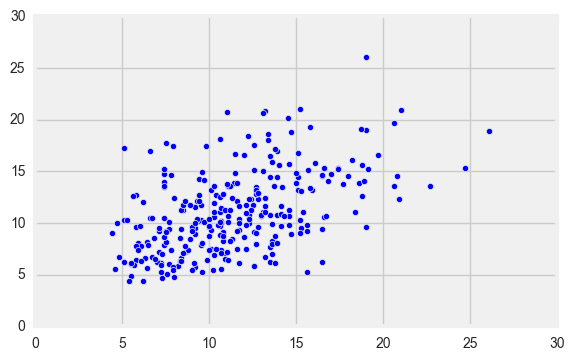

In [105]:
plt.scatter(X_train.iloc[:,1],y_train) #scatter plot of FPTS/G .507

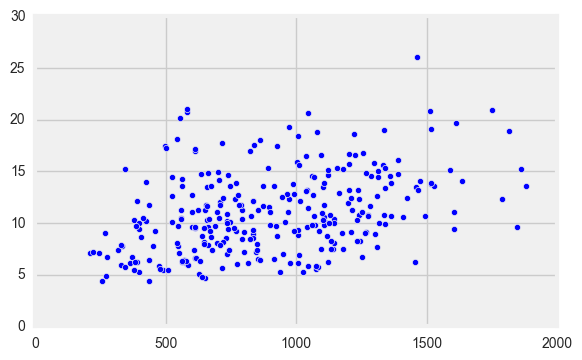

In [140]:
plt.scatter(X_train.iloc[:,7],y_train) #scatter plot of rush yards 0.416

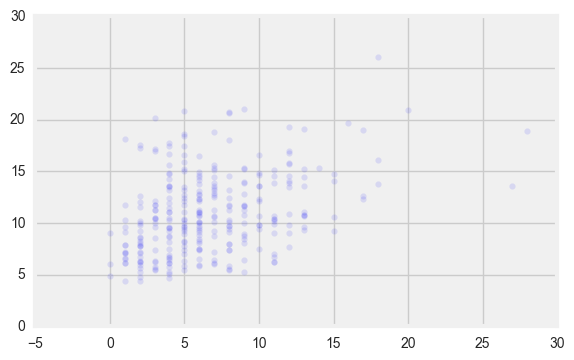

In [141]:
plt.scatter(X_train.iloc[:,6],y_train, alpha=.1) #scatter of RUSH TDs #0.371

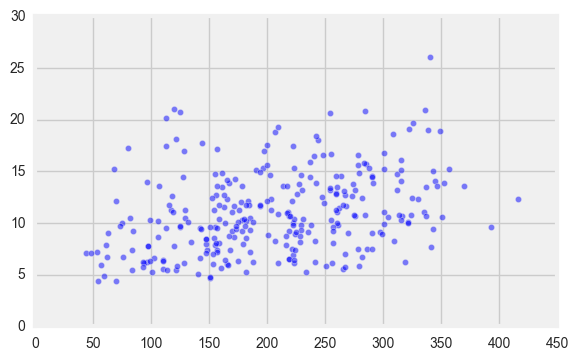

In [143]:
plt.scatter(X_train.iloc[:,0],y_train, alpha=.5) #scatter of ATTEMPTS 0.371

### PAIRPLOT

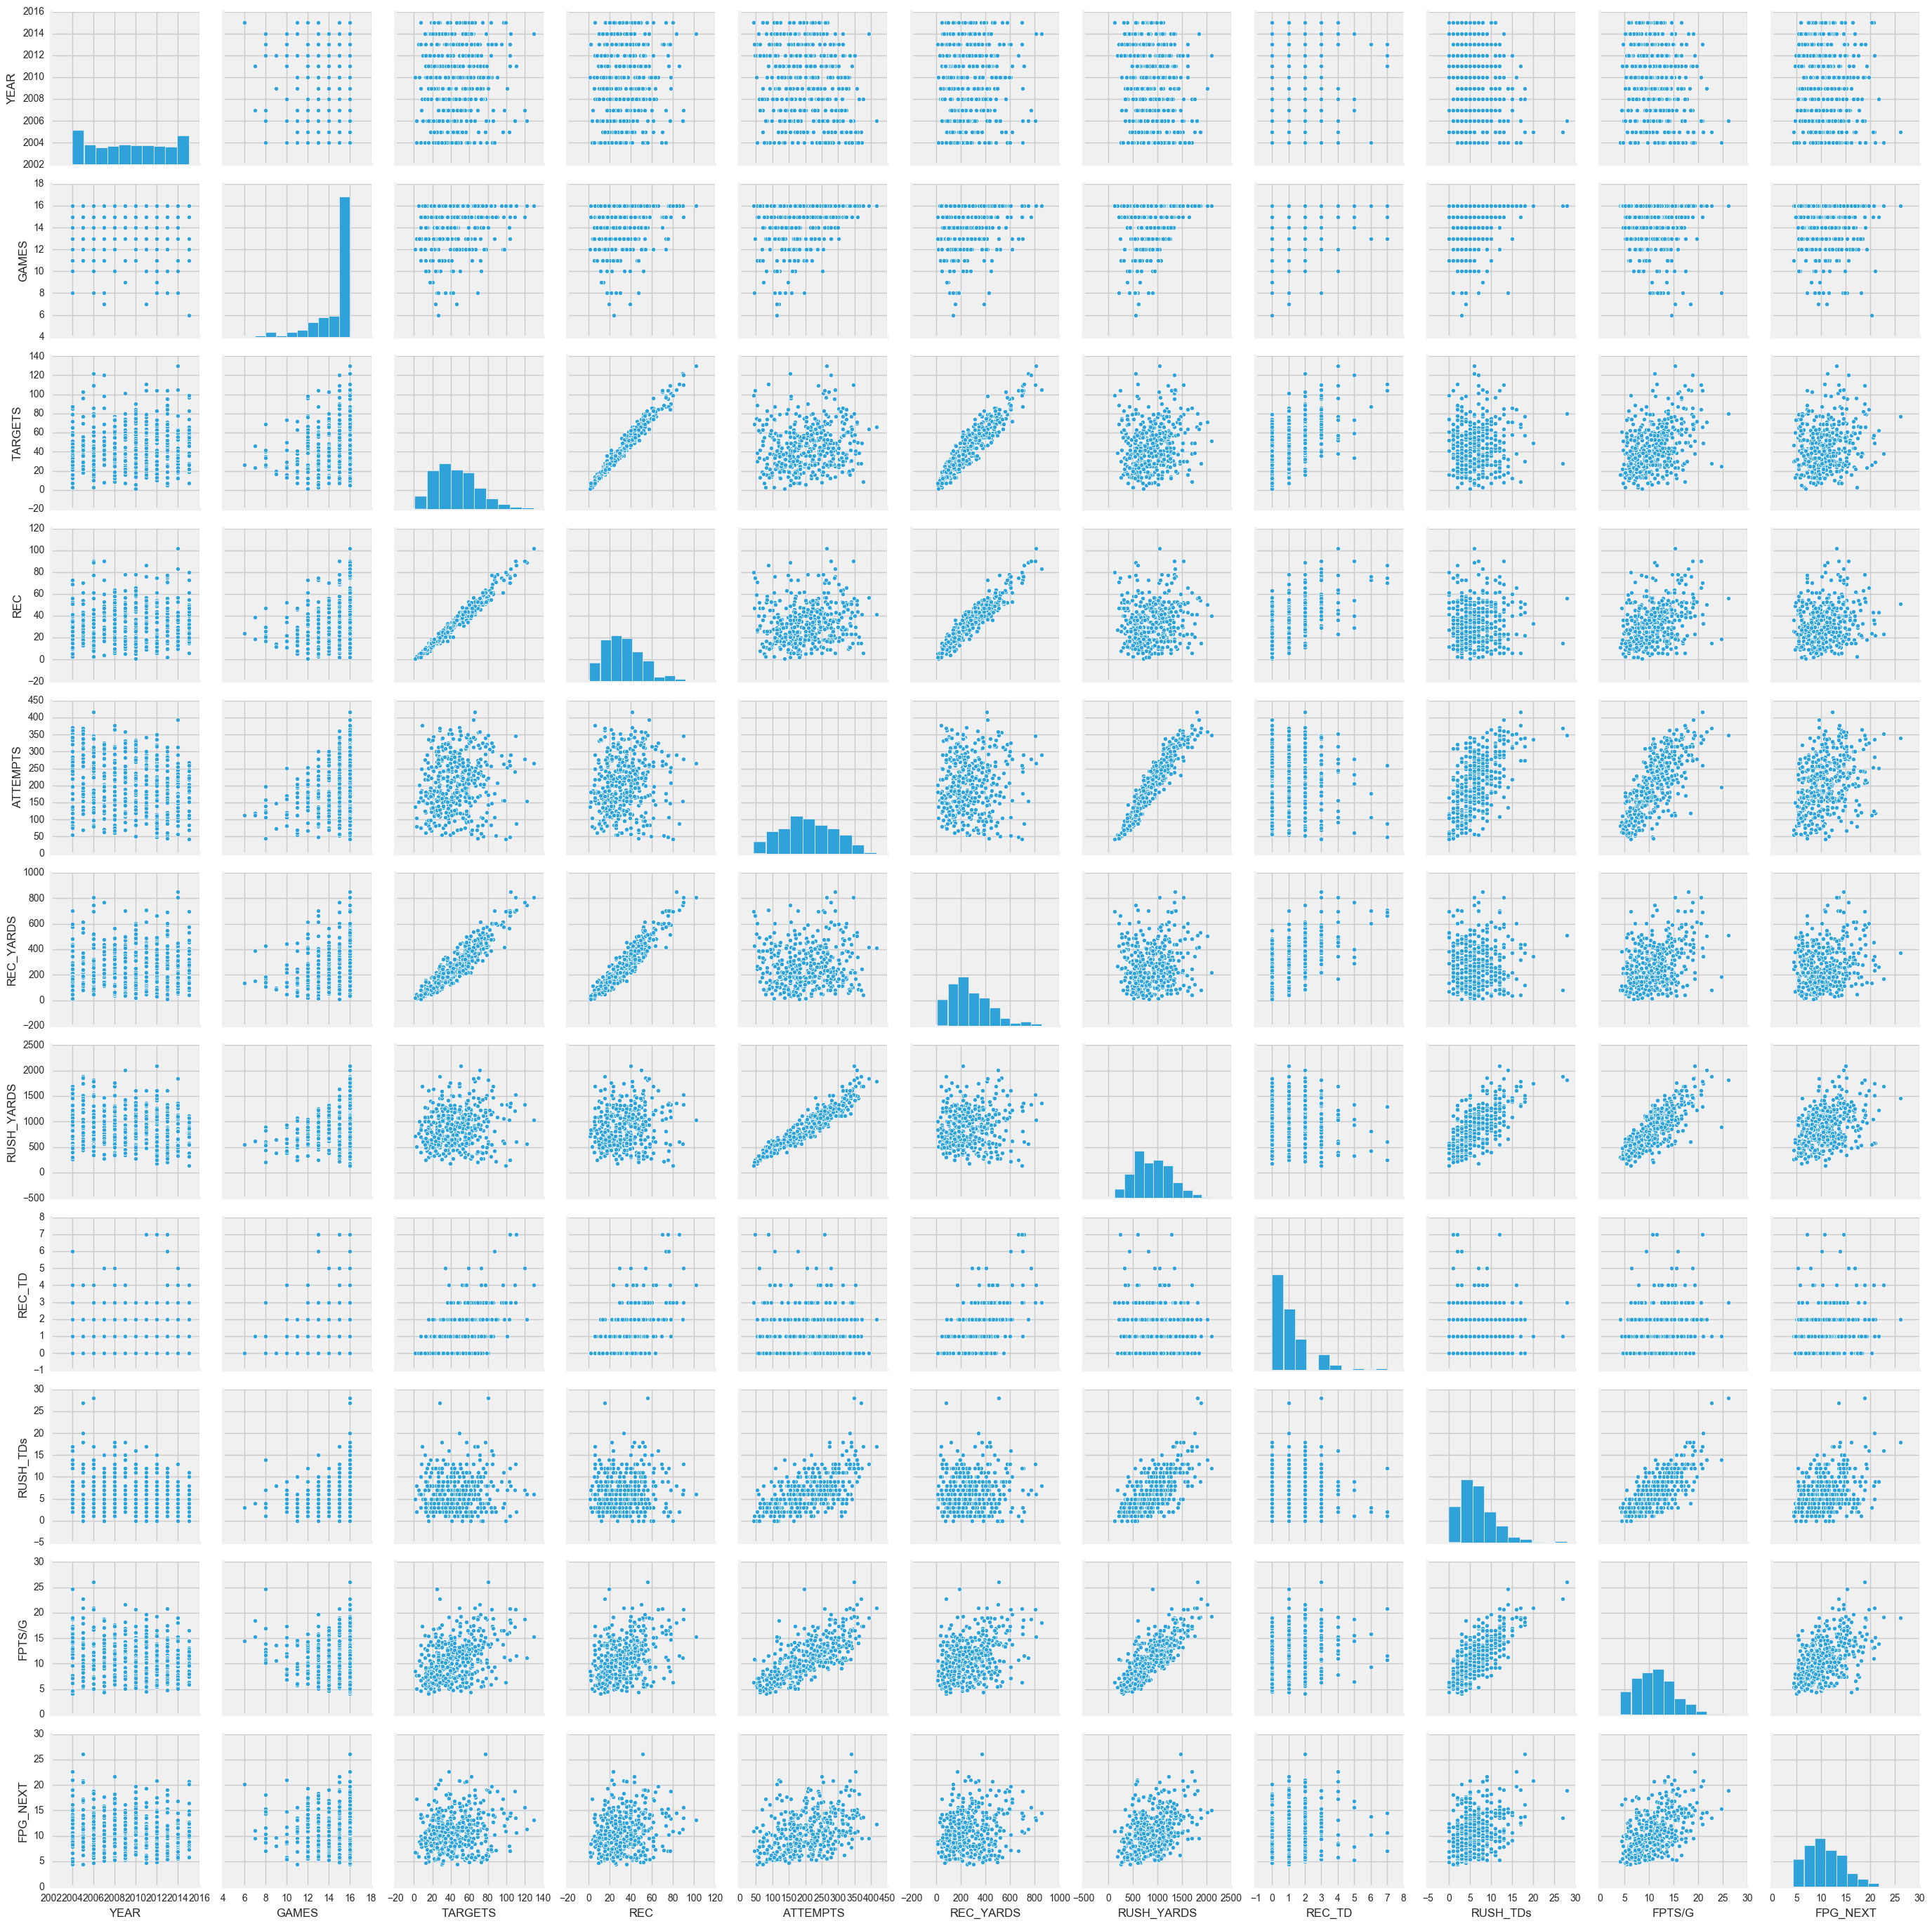

In [108]:
sns.pairplot(fantasy)

### SINGLE TREE

In [193]:
from sklearn import tree
dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)
dtrmodel.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [194]:
dtrmodel.tree_

In [195]:
tree.export_graphviz(dtrmodel, out_file='tree2.dot',feature_names = X_train.columns)


In [196]:
!head tree.dot
#go to http://webgraphviz.com 

digraph Tree {
node [shape=box] ;
0 [label="FPTS/G <= 10.95\nmse = 15.1175\nsamples = 292\nvalue = 10.9866"] ;
1 [label="REC_YARDS <= 337.0\nmse = 9.6508\nsamples = 146\nvalue = 9.3068"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="FPTS/G <= 7.35\nmse = 10.1401\nsamples = 113\nvalue = 9.7575"] ;
1 -> 2 ;
3 [label="REC <= 15.5\nmse = 9.8181\nsamples = 34\nvalue = 8.3676"] ;
2 -> 3 ;
4 [label="mse = 12.1175\nsamples = 13\nvalue = 10.1692"] ;


In [197]:
list(zip(dtrmodel.tree_.feature,dtrmodel.tree_.threshold))[:10]
#prints out the insides of each node, all leaf nodes are -2, root is 1. 

[(1, 10.949999809265137),
 (5, 337.0),
 (1, 7.3500003814697266),
 (3, 15.5),
 (-2, -2.0),
 (9, 2009.5),
 (-2, -2.0),
 (-2, -2.0),
 (0, 121.5),
 (-2, -2.0)]

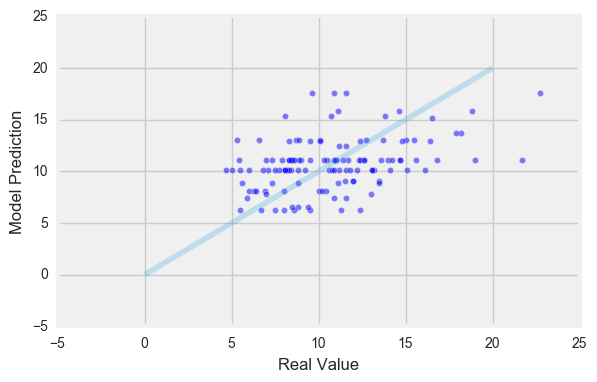

In [114]:
tree_pred_test = dtrmodel.predict(X_test)
plt.scatter(y_test, tree_pred_test,alpha=.5) #alpha is the density of color
#X is the real value, Y is the "model prediction"
plt.plot(np.linspace(0,20,100),np.linspace(0,20,100),alpha=0.25) #to drag out image
plt.xlabel('Real Value')
plt.ylabel('Model Prediction')

In [115]:
np.sqrt(np.mean((tree_pred_test - y_test)**2))

3.4446768049932226

### LINEAR REGRESSION

In [116]:
from sklearn.linear_model import LinearRegression

In [117]:
X_train.columns

Index([u'ATTEMPTS', u'FPTS/G', u'GAMES', u'REC', u'REC_TD', u'REC_YARDS',
       u'RUSH_TDs', u'RUSH_YARDS', u'TARGETS', u'YEAR'],
      dtype='object')

In [118]:
selected_columns = ['FPTS/G']

In [119]:
lrmodel1 = LinearRegression()
lrmodel1.fit(X_train.loc[:,selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [120]:
lr1_test_pred = lrmodel1.predict(X_test.loc[:,selected_columns]) #test prediction for FPTS/G

In [ ]:
# lr1_test_pred2 = lrmodel1.predict(X_test.loc[:,selected_columns]) #try this for Rush TD

In [121]:
lrmodel1.coef_, lrmodel1.intercept_

(array([ 0.50079711]), 5.2837310129687687)

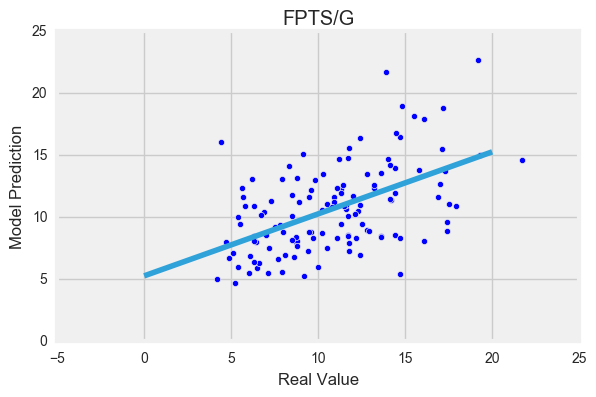

In [202]:
plt.scatter(X_test[selected_columns],y_test)
plt.plot(np.linspace(0,20,20),.5*np.linspace(0,20,20)+5.28)
#plt.plot(np.linspace(0,20,20),np.linspace(0,20,20))
plt.xlabel('Real Value')
plt.ylabel('Model Prediction')
plt.title('FPTS/G')

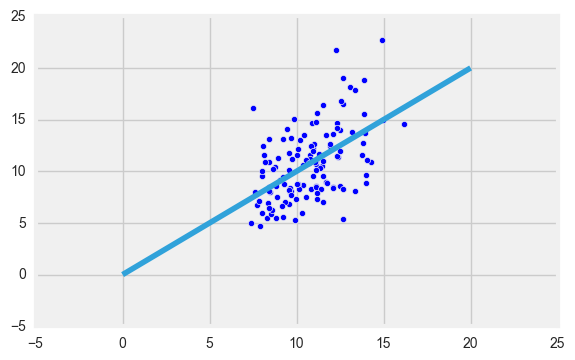

In [123]:
#plt.scatter(.5008*X_test[selected_columns]+5.283,y_test)
plt.scatter(lr1_test_pred,y_test)
#plt.plot(np.linspace(0,20,20),.5*np.linspace(0,20,20)+5.28)
plt.plot(np.linspace(0,20,20),np.linspace(0,20,20))

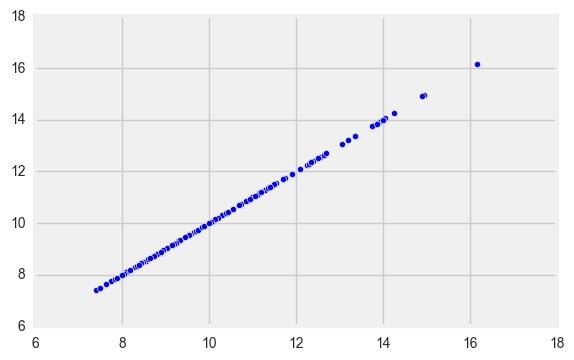

In [124]:
plt.scatter(.5008*X_test[selected_columns]+5.283,lr1_test_pred)


In [125]:
np.sqrt(np.mean((lr1_test_pred-y_test)**2))

3.0222854779252724

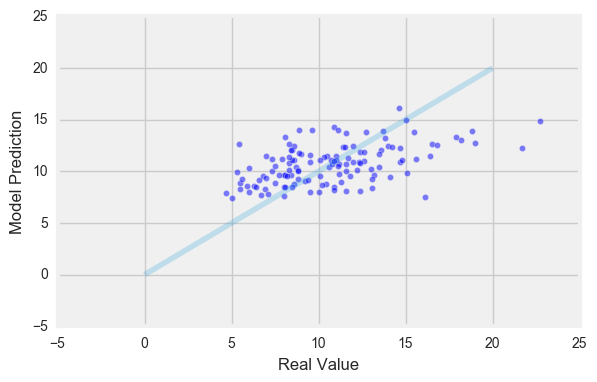

In [126]:
plt.scatter(y_test, lr1_test_pred,alpha=.5)
plt.plot(np.linspace(0,20,100),np.linspace(0,20,100), alpha=0.25)

plt.xlabel('Real Value')
plt.ylabel('Model Prediction')

### RANDOM FOREST

In [127]:
from sklearn.ensemble import RandomForestRegressor #random tree 

In [165]:
rfmodel1 = RandomForestRegressor(n_estimators = 500, min_samples_leaf=10, min_samples_split=10, max_features=2, n_jobs=-1) #n_jobs depends on processor, tell computer how many processors to use.
#n_jobs=-1 means use ALL processors
rfmodel1.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [166]:
rf1_test_pred = rfmodel1.predict(X_test) #X_test is saved from the earlier test set 

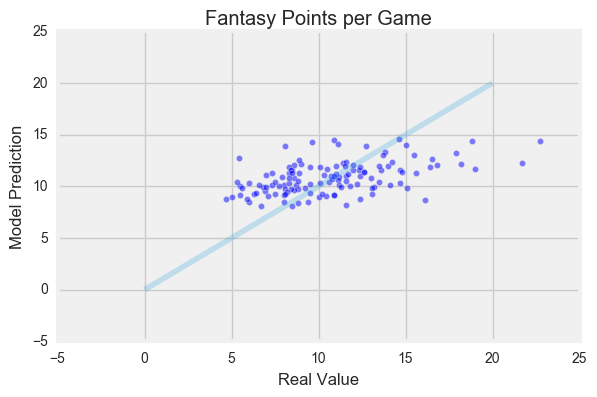

In [199]:
plt.scatter(y_test, rf1_test_pred,alpha=.5)
plt.plot(np.linspace(0,20,100),np.linspace(0,20,100), alpha=0.25)

plt.xlabel('Real Value')
plt.ylabel('Model Prediction')
plt.title('Fantasy Points per Game')

In [167]:
np.sqrt(np.mean((rf1_test_pred - y_test)**2)) #rf1 test pred is guesses of test data of FPTS/G
#error score for all the features, aggregated.

3.0531816760507207

In [132]:
rfmodel1.feature_importances_

array([ 0.11295616,  0.2765008 ,  0.03993941,  0.05357933,  0.03542427,
        0.09647916,  0.12440974,  0.1506677 ,  0.06641203,  0.04363141])

In [133]:
X_test.head()

,ATTEMPTS,FPTS/G,GAMES,REC,REC_TD,REC_YARDS,RUSH_TDs,RUSH_YARDS,TARGETS,YEAR
637,54,5.4,16,27,0,268,7,183,39,2012
644,91,6.0,12,15,0,156,4,325,22,2012
743,106,10.2,8,21,1,139,3,434,34,2014
273,206,9.6,15,34,1,372,2,882,48,2005
415,238,12.3,15,52,2,417,7,885,61,2008


In [134]:
X_test.shape

(126, 10)

In [135]:
rf1_test_pred #these are the guesses 

array([  8.50348338,   9.12089071,  10.0150988 ,   9.65322919,
        11.38405547,  10.09448229,  14.22186661,  10.95223939,
        11.53852883,   8.33703738,  13.33738305,   9.67265294,
         8.16736046,   9.10388944,   8.73377347,  14.65661448,
        10.34410309,  10.69013716,  10.45578685,  10.03085615,
         9.13113532,  10.01378984,  10.40330186,  12.0775951 ,
        12.87467576,  12.05450562,  11.94650696,  12.20966342,
        10.09938996,  11.39084554,   9.63614379,  11.14143119,
        12.24283665,   9.6527439 ,  11.61692073,   9.74371516,
        10.1939905 ,  11.17300572,   8.18385016,  11.08633796,
        13.8600613 ,   8.9527498 ,  11.95324639,  14.00990356,
        12.51924124,  10.84786861,  12.16140211,  12.88220614,
        10.98939997,   9.35510248,  14.29541316,  11.75459349,
        10.43454567,  10.97437921,  11.1340902 ,   9.65003628,
        11.68275743,   8.31543859,   9.95777088,  11.32161836,
        12.35503641,  10.02975562,   9.98363516,   9.50

### BOOSTING

In [136]:
from sklearn.ensemble import GradientBoostingRegressor #to do boosting tree

In [181]:
gbmodel1 = GradientBoostingRegressor(subsample=.8, n_estimators=3000, learning_rate=0.0001, max_depth=3, min_samples_leaf=10, min_samples_split=20)
gbmodel1.fit(X_train, y_train) #subsample means only use a percentage of data
#n estimators how many trees you keep making

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.0001, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=10,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

In [182]:
gb1_test_pred = gbmodel1.predict(X_test)

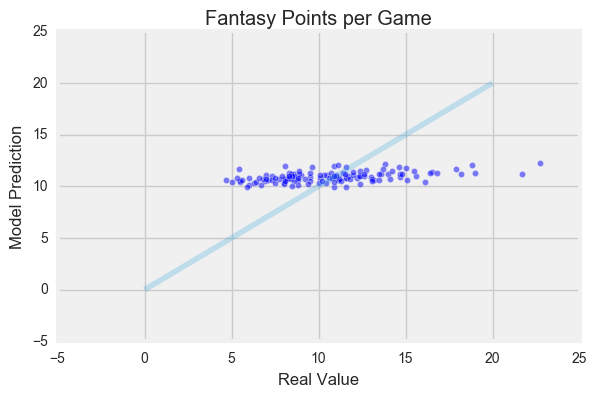

In [201]:
plt.scatter(y_test, gb1_test_pred,alpha=.5)
plt.plot(np.linspace(0,20,100),np.linspace(0,20,100), alpha=0.25)

plt.xlabel('Real Value')
plt.ylabel('Model Prediction')
plt.title('Fantasy Points per Game')

In [183]:
np.sqrt(np.mean((gb1_test_pred-y_test)**2)) 

3.3084545134039995